# Scaling the regularization parameter for SVCs
- 분류에 서포트 벡터 머신을 사용할 때 정규화 매개변수 스케일리의 효과

## Data generation

In [1]:
from sklearn.datasets import make_classification

n_samples, n_features = 100, 300
X, y = make_classification(
    n_samples=n_samples, n_features=n_features, n_informative=5, random_state=1
)

## L1-penalty case

In [2]:
from sklearn.svm import LinearSVC

model_l1 = LinearSVC(penalty="l1", loss="squared_hinge", dual=False, tol=1e-3)

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import ShuffleSplit, validation_curve

Cs = np.logspace(-2.3, -1.3, 10)
train_sizes = np.linspace(0.3, 0.7, 3)
labels = [f"fraction: {train_size}" for train_size in train_sizes]
shuffle_params = {
    "test_size": 0.3,
    "n_splits": 150,
    "random_state": 1,
}

results = {"C": Cs}
for label, train_size in zip(labels, train_sizes):
    cv = ShuffleSplit(train_size=train_size, **shuffle_params)
    train_scores, test_scores = validation_curve(
        model_l1,
        X,
        y,
        param_name="C",
        param_range=Cs,
        cv=cv,
        n_jobs=2,
    )
    results[label] = test_scores.mean(axis=1)
results = pd.DataFrame(results)

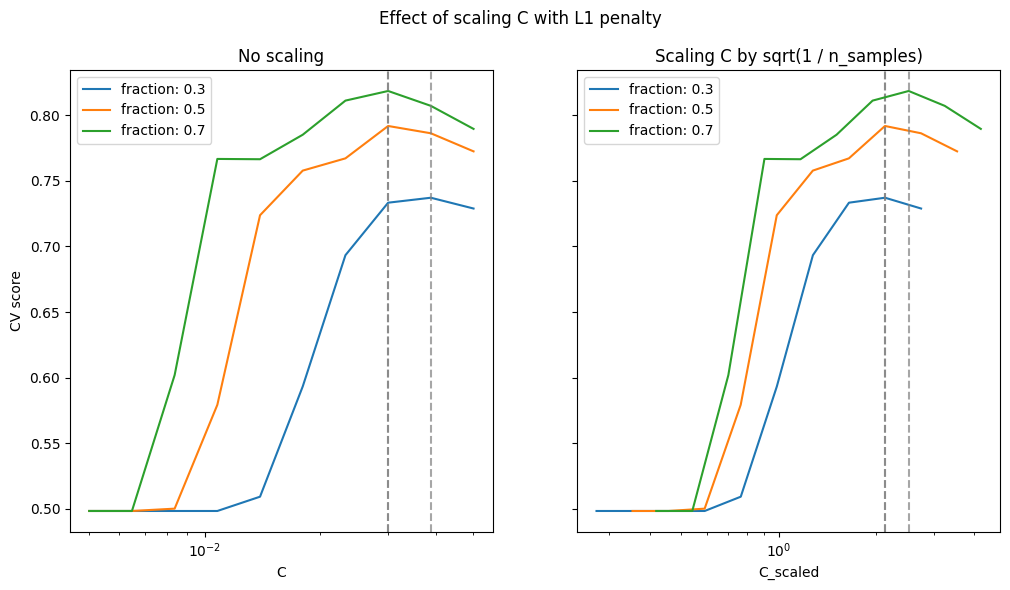

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# C를 스케일링 없이 결과를 플롯
results.plot(x="C", ax=axes[0], logx=True)
axes[0].set_ylabel("CV score")
axes[0].set_title("No scaling")

for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    axes[0].axvline(x=best_C, linestyle="--", color="grey", alpha=0.7)

# C를 스케일링 하고 결과를 플롯
for train_size_idx, label in enumerate(labels):
    train_size = train_sizes[train_size_idx]
    results_scaled = results[[label]].assign(
        C_scaled=Cs * float(n_samples * np.sqrt(train_size))
    )
    results_scaled.plot(x="C_scaled", ax=axes[1], logx=True, label=label)
    best_C_scaled = results_scaled["C_scaled"].loc[results[label].idxmax()]
    axes[1].axvline(x=best_C_scaled, linestyle="--", color="grey", alpha=0.7)

axes[1].set_title("Scaling C by sqrt(1 / n_samples)")

_ = fig.suptitle("Effect of scaling C with L1 penalty")

## L2-penalty case

In [5]:
model_l2 = LinearSVC(penalty="l2", loss="squared_hinge", dual=True)
Cs = np.logspace(-8, 4, 11)

labels = [f"fraction: {train_size}" for train_size in train_sizes]
results = {"C": Cs}
for label, train_size in zip(labels, train_sizes):
    cv = ShuffleSplit(train_size=train_size, **shuffle_params)
    train_scores, test_scores = validation_curve(
        model_l2,
        X,
        y,
        param_name="C",
        param_range=Cs,
        cv=cv,
        n_jobs=2,
    )
    results[label] = test_scores.mean(axis=1)
results = pd.DataFrame(results)

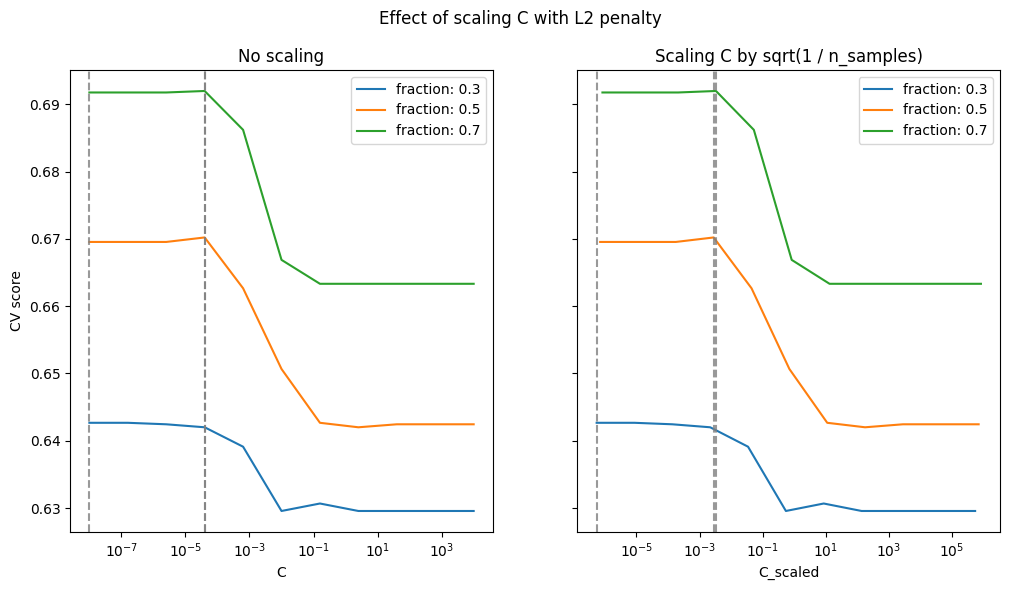

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# C를 스케일링 없이 결과를 플롯
results.plot(x="C", ax=axes[0], logx=True)
axes[0].set_ylabel("CV score")
axes[0].set_title("No scaling")

for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    axes[0].axvline(x=best_C, linestyle="--", color="grey", alpha=0.8)

# C를 스케일링 하고 결과를 플롯
for train_size_idx, label in enumerate(labels):
    results_scaled = results[[label]].assign(
        C_scaled=Cs * float(n_samples * np.sqrt(train_sizes[train_size_idx]))
    )
    results_scaled.plot(x="C_scaled", ax=axes[1], logx=True, label=label)
    best_C_scaled = results_scaled["C_scaled"].loc[results[label].idxmax()]
    axes[1].axvline(x=best_C_scaled, linestyle="--", color="grey", alpha=0.8)
axes[1].set_title("Scaling C by sqrt(1 / n_samples)")

fig.suptitle("Effect of scaling C with L2 penalty")
plt.show()